In [1]:
!pip install astroNN --quiet
!pip install torchmetrics --quiet
!pip install scikit-image --quiet
!pip install mlflow --quiet

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torchmetrics
from torchinfo import summary

from collections import Counter

from utils.focal_loss import FocalLoss
import utils.general as g
from cnn import NeuralNet

import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astroNN.datasets import load_galaxy10

import skimage as ski

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("galaxy-classifier-experiment")
torch.manual_seed(42)
np.random.seed(42)
torch.__version__

/home/arpoca/GalaxyClassifier/.venv/lib/python3.12/site-packages/astroNN/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution
2025-06-29 15:22:19.519024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751221339.531786    5946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751221339.535439    5946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751221339.556789    5946 computation_placer.cc:17

'2.7.1+cu126'

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
class_names = [
    "0 - Disturbed Galaxies",
    "1 - Merging Galaxies",
    "2 - Round Smooth Galaxies",
    "3 - In-between Round Smooth Galaxies",
    "4 - Cigar Shaped Smooth Galaxies",
    "5 - Barred Spiral Galaxies",
    "6 - Unbarred Tight Spiral Galaxies",
    "7 - Unbarred Loose Spiral Galaxies",
    "8 - Edge-on Galaxies without Bulge",
    "9 - Edge-on Galaxies with Bulge"
]

In [5]:
images,labels = g.get_data('/home/arpoca/GalaxyClassifier/src/data')

In [6]:
images.shape

(17736, 256, 256, 3)

In [7]:
def get_label_count(labels):
  counts = np.unique(labels, return_counts=True)
  return counts[1].tolist()

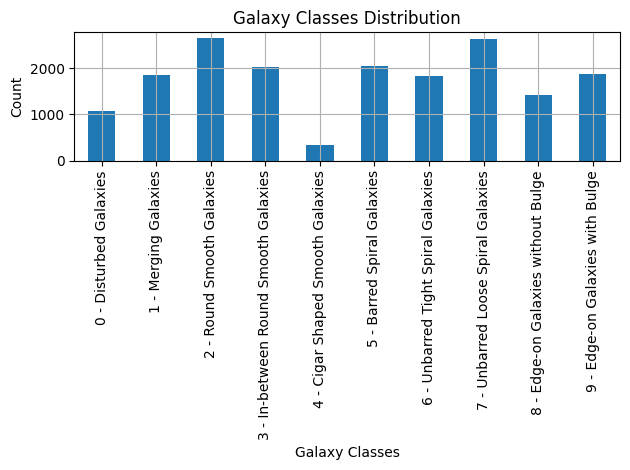

In [8]:
c = Counter(labels)
df = pd.DataFrame.from_dict(c,orient='index').transpose()
df.columns = class_names
df = df.transpose()

df.plot(kind='bar', legend=False)
plt.title('Galaxy Classes Distribution')
plt.ylabel('Count')
plt.xlabel('Galaxy Classes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid()
plt.show()


In [9]:
images_path = '/home/arpoca/GalaxyClassifier/src/data/images.npy'
labels_path = '/home/arpoca/GalaxyClassifier/src/data/labels.npy'

In [10]:
original_indices = np.arange(len(images))

train_indices, temp_indices = train_test_split(
    original_indices, test_size=0.4, stratify=labels, random_state=42
)

val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=labels[temp_indices], random_state=42
)

train_dataset, test_dataset, valid_dataset = g.get_dataset(
    train_indices, test_indices, val_indices, images_path, labels_path
)


In [11]:
train_labels = labels[train_indices]
num_samples_per_class = get_label_count(train_labels)
num_samples_per_class

[648, 1112, 1587, 1216, 200, 1226, 1097, 1577, 854, 1124]

In [12]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

333
111
111


In [13]:
# Hyperparameters

beta = 0.999
gamma = 4.0
epochs = 50
lr = 1e-1

In [14]:
model = NeuralNet().to(device)
loss = FocalLoss(
    beta=beta,
    gamma=gamma,
    samples_per_class=num_samples_per_class,
    reduce=True
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
#loss = nn.CrossEntropyLoss()

In [16]:
def train_book(model, optimizer, criterion, train_loader, n_epochs, device):
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    train_accuracies = []
    train_losses = []
    
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model, input_size=(batch_size, 3, 256, 256))))
    mlflow.log_artifact("model_summary.txt")
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch).to(device)

            # Ensure y_batch is integer indices
            if y_batch.dtype != torch.long:
                y_batch = y_batch.long()
        
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()

            _, predicted = y_pred.max(1)
            loss.backward()
            optimizer.step()

            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()
            
            if batch_idx % 100 == 0:
                batch_loss = total_loss / (batch_idx + 1)
                batch_acc = 100.0 * correct / total
                mlflow.log_metrics(
                    {"batch_loss": batch_loss, "batch_accuracy": batch_acc},
                    step=epoch * len(train_loader) + batch_idx,
                )
        epoch_accuracy = 100 * correct / total
        train_losses.append(total_loss)
        train_accuracies.append(epoch_accuracy)
                
        model.eval()
        accuracy.reset()
        all_predictions = []
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                _, predicted_class = torch.max(y_pred, 1)  
                all_predictions.extend(predicted_class.cpu().numpy())
                accuracy.update(predicted_class, y_batch)  

        valid_accuracy = accuracy.compute()

        accuracy.reset()
        with torch.no_grad():
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                _, predicted_class = torch.max(y_pred, 1)  
                all_predictions.extend(predicted_class.cpu().numpy())
                accuracy.update(predicted_class, y_batch)  
        
        train_accuracy = accuracy.compute()
        pred_distribution = Counter(all_predictions)
        #print(f"Predicted class distribution: {pred_distribution}")
        mean_loss = total_loss / len(train_loader)
        mlflow.log_metric("train_loss", f"{mean_loss:.6f}",step=epoch)
        mlflow.log_metric("train_accuracy",f"{train_accuracy:.6f}",step=epoch)
        mlflow.log_metric("validation_accuracy",f"{valid_accuracy:.6f}",step=epoch)
        
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {mean_loss:.6f}, Train Accuracy: {train_accuracy:.6f}, Validation Accuracy: {valid_accuracy:.6f}")


In [ ]:
with mlflow.start_run() as run:
    # Save parameters to mlflow
    params = {
          "epochs": epochs,
          "learning_rate": lr,
          "batch_size": 32,
          "loss_function": loss.__class__.__name__,
          "lf_beta": beta,
          "lf_gamma": gamma,
          "optimizer": "SGD",
    }
    mlflow.log_params(params)
    train_book(model, optimizer, loss, train_loader, n_epochs=epochs,device=device)
torch.cuda.empty_cache()

Epoch 1/50, Loss: 1.202208, Train Accuracy: 0.149140, Validation Accuracy: 0.149140
Epoch 2/50, Loss: 1.138709, Train Accuracy: 0.254957, Validation Accuracy: 0.250352
Epoch 3/50, Loss: 0.955970, Train Accuracy: 0.297340, Validation Accuracy: 0.290386


In [ ]:
model.eval()
metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=10).to(device)

with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_logits = model(X_batch)  # Raw logits [batch_size, 10]

        # Convert logits to predicted class indices
        _, y_pred_classes = torch.max(y_pred_logits, 1)

        metric.update(y_pred_classes, y_batch)  

conf_matrix = metric.compute()

# Calculate precision, recall, and F1-score from the confusion matrix
for i, class_name in enumerate(class_names):
    tp = conf_matrix[i, i].item()
    fp = conf_matrix[:, i].sum().item() - tp
    fn = conf_matrix[i, :].sum().item() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Metrics for {class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1_score:.4f}")

In [ ]:
print("=== DEBUGGING EVALUATION ===")
model.eval()

# Check what the model actually predicts during evaluation
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in valid_loader:  # Use the SAME loader as training
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_logits = model(X_batch)
        _, y_pred_classes = torch.max(y_pred_logits, 1)

        all_preds.extend(y_pred_classes.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

print(f"EVALUATION - Predicted distribution: {Counter(all_preds)}")
print(f"EVALUATION - Target distribution: {Counter(all_targets)}")

metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=10).to(device)

with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_logits = model(X_batch)
        _, y_pred_classes = torch.max(y_pred_logits, 1)
        metric.update(y_pred_classes, y_batch)

conf_matrix = metric.compute()
print(f"Confusion matrix shape: {conf_matrix.shape}")
print(f"Confusion matrix:\n{conf_matrix}")


In [ ]:
len(valid_loader)    